In [120]:
# Import libs
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# create db
from sqlalchemy import create_engine

In [121]:
# Aesthetic settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [122]:
# download data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/netflix-shows")

print("Path to dataset files:", path)

Path to dataset files: /home/brenddon/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5


In [123]:
df = pd.read_csv(f'{path}/netflix_titles.csv')

In [124]:
print(df.columns)

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


## Missing Values

In [125]:
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 director      2634
cast           825
country        831
date_added      10
rating           4
duration         3
dtype: int64


## How many titles are films or series

type
Movie      6131
TV Show    2676
Name: count, dtype: int64


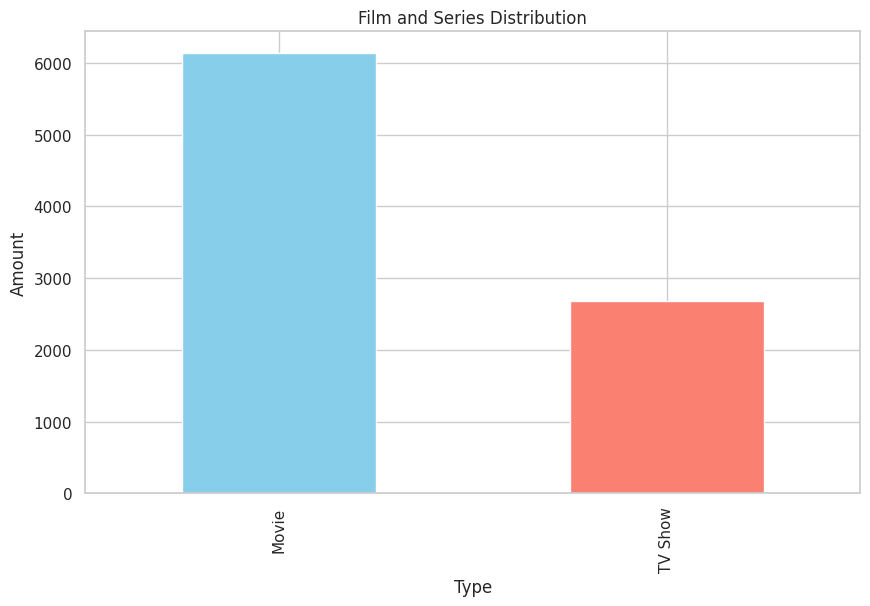

In [126]:
type_counts = df['type'].value_counts()
print(type_counts)

type_counts.plot(kind='bar', color=['skyblue', 'salmon'], grid=True)
plt.title("Film and Series Distribution")
plt.xlabel("Type")
plt.ylabel("Amount")
plt.show()

## Number of titles by year of release

In [127]:
release_counts= df['release_year'].value_counts().sort_index()

# Top 10 years release
release_counts.sort_values().tail(10)

release_year
2012     237
2013     288
2014     352
2015     560
2021     592
2016     902
2020     953
2019    1030
2017    1032
2018    1147
Name: count, dtype: int64

In [128]:

amount = df.groupby(['release_year', 'type']).size().reset_index(name='amount')
amount = amount.sort_values(by='release_year')

# Transform types in separate columns
amount = amount.pivot(index='release_year', columns='type', values='amount').fillna(0)

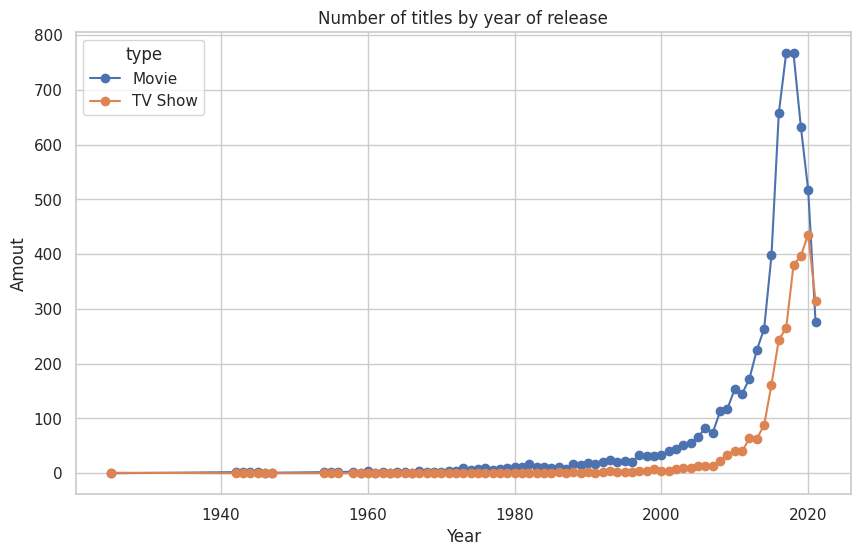

In [129]:
amount.plot(kind='line', marker='o', grid=True)
plt.title('Number of titles by year of release')
plt.xlabel('Year')
plt.ylabel('Amout')
plt.show()

## Distribution of age ratings

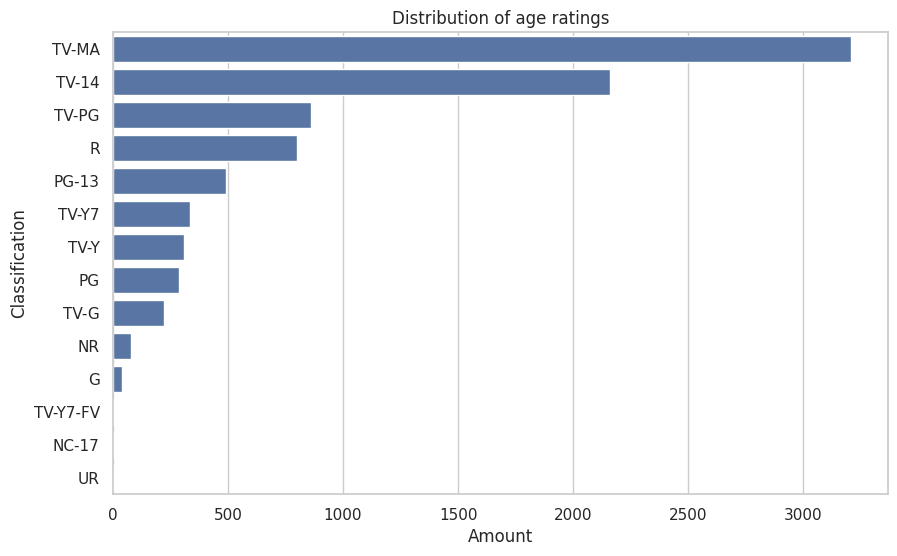

In [130]:
rating_counts = df['rating'].value_counts()

# processing incorrect data
rating_counts = rating_counts.drop(index=['66 min', '74 min', '84 min'])

sns.barplot(x=rating_counts.values, y=rating_counts.index)
plt.title("Distribution of age ratings")
plt.xlabel("Amount")
plt.ylabel("Classification")
plt.show()

Average length of films:: 99.57718668407311


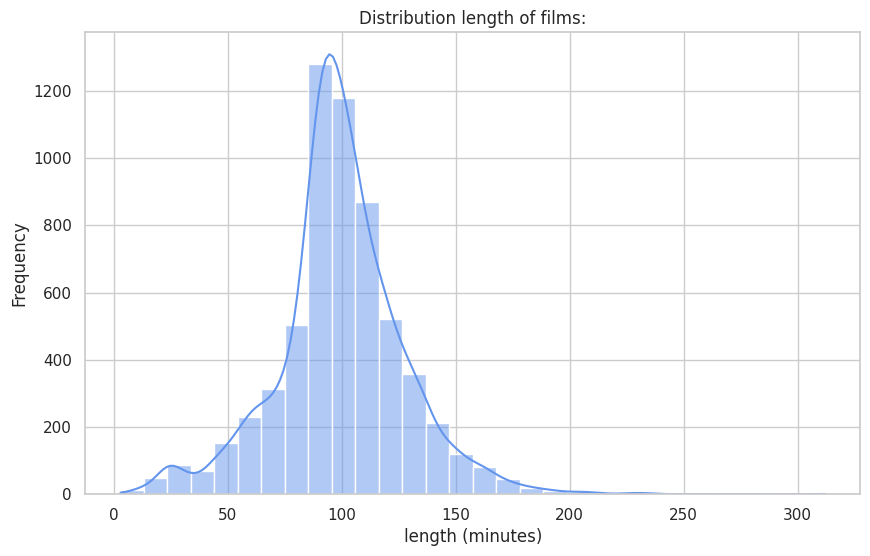

In [131]:
# Filtra apenas filmes
movies = df[df['type'] == 'Movie'].copy()

# Extrai número da duração (ex: "90 min" → 90)
movies['duration_min'] = movies['duration'].str.extract(r'(\d+)').astype(float)

print("Average length of films::", movies['duration_min'].mean())

sns.histplot(movies['duration_min'], bins=30, kde=True, color='cornflowerblue')
plt.title("Distribution length of films:")
plt.xlabel("length (minutes)")
plt.ylabel("Frequency")
plt.show()


Average number of seasons: 1.764947683109118


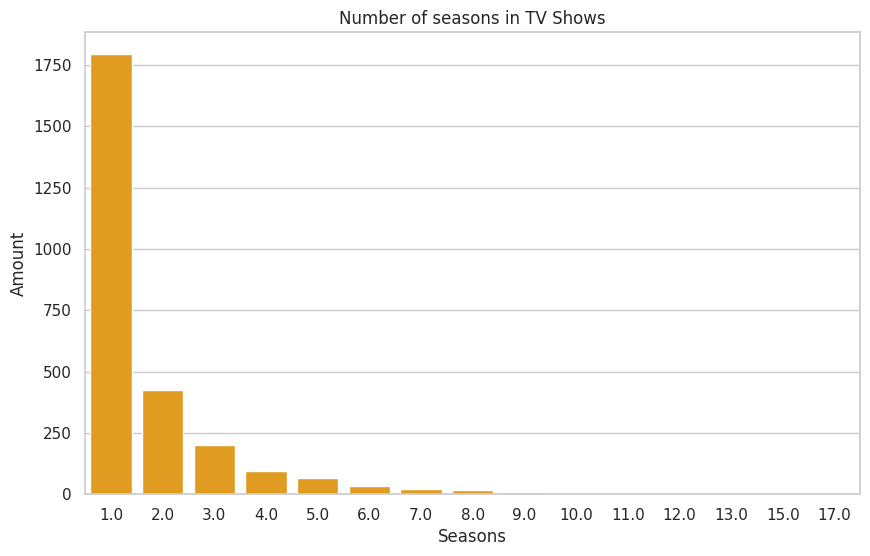

In [132]:
tv_shows = df[df['type'] == 'TV Show'].copy()
tv_shows['seasons'] = tv_shows['duration'].str.extract(r'(\d+)').astype(float)

print("Average number of seasons:", tv_shows['seasons'].mean())

sns.countplot(x=tv_shows['seasons'], color='orange')
plt.title("Number of seasons in TV Shows")
plt.xlabel("Seasons")
plt.ylabel("Amount")
plt.show()


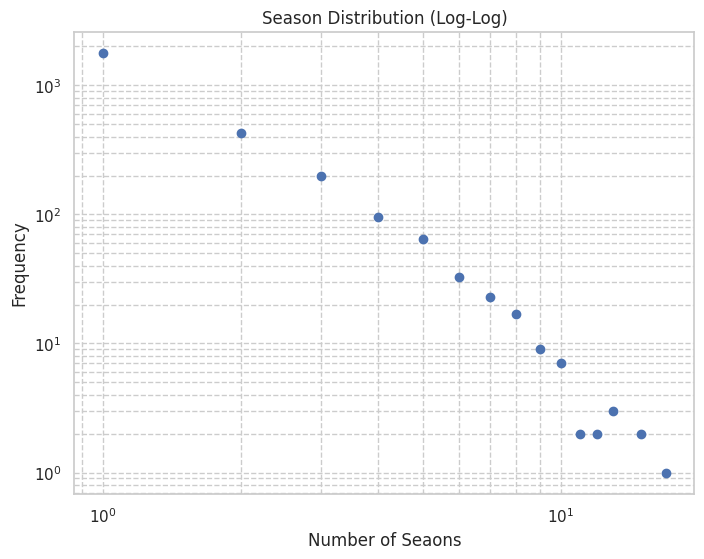

In [133]:
frequencies = tv_shows['seasons'].value_counts().sort_index()

x = frequencies.index
y = frequencies.values

plt.figure(figsize=(8,6))
plt.loglog(x, y, marker='o', linestyle='none')
plt.title('Season Distribution (Log-Log)')
plt.xlabel('Number of Seaons')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="--")
plt.show()


Calculating best minimal value for power law fit
alpha: 5.169673180405641
xmin: 8.0


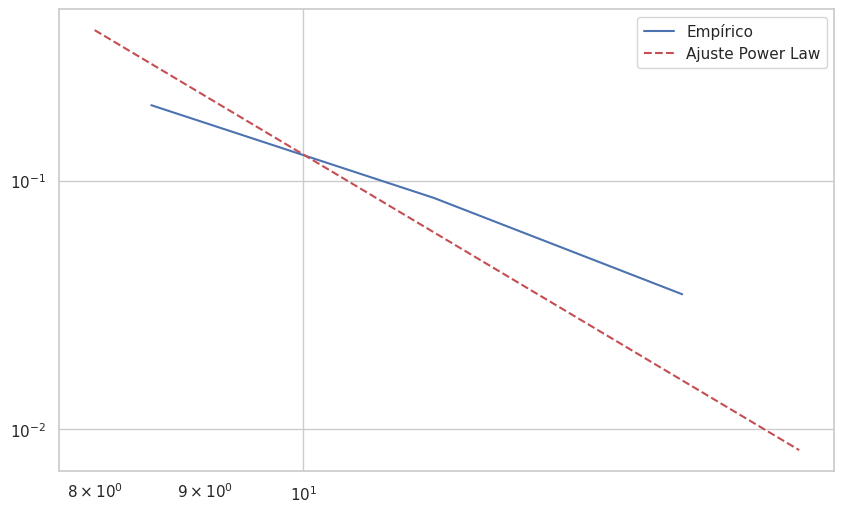

In [134]:
import powerlaw

data = tv_shows['seasons'].dropna().values
fit = powerlaw.Fit(data, discrete=True)

# Estimar o expoente alpha
print('alpha:', fit.alpha)
print('xmin:', fit.xmin)

# Plotar distribuição com o ajuste
fig = fit.plot_pdf(color='b', label='Empírico')
fit.power_law.plot_pdf(color='r', linestyle='--', label='Ajuste Power Law', ax=fig)
plt.legend()
plt.show()
